In [1]:
#%pip install --force-reinstall pytesseract

In [138]:
from mss import mss
from matplotlib import pyplot as plt
from gym import Env
from gym.spaces import Box, Discrete
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
import os
import pydirectinput
import cv2
import numpy as np
import pytesseract
import time

In [139]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [135]:
from numpy import int8


class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,83,200), dtype=np.int8)
        self.action_space = Discrete(3)
        
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 1200, 'height': 500}
        self.done_location = {'top': 385, 'left': 630, 'width': 660, 'height': 70}
        
        pass
    
    def step(self, action):
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])
            
        res, done, done_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1 
        info = {}
        
        return new_observation, reward, done, info
    
    def reset(self):
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation().astype('int8')
    
    def close(self):
        cv2.destroyAllWindows()
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) % 0xFF == ord('q'):
            self.close()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (200, 83))
        channel = np.reshape(resized, (1,83, 200))
        
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done = False
        done_strings = ['GAME', 'GAHE', 'GAKN', 'GA E', 'GARn', 'GARH', 'GARE']
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        
        return res, done, done_cap

In [140]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [141]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [142]:
env = WebGame()

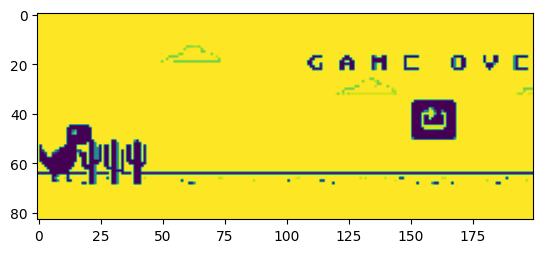

In [127]:
plt.imshow(env.get_observation()[0])

In [128]:
episodes = 5
for episode in range(1, episodes+1):
    obs = env.reset()
    score = 0
    done = False
    while not done:
        env.render()
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
    print(f"episode - {episode} || score - {score}")
env.close()

episode - 0 || score - 10
episode - 1 || score - 42
episode - 2 || score - 13
episode - 3 || score - 13
episode - 4 || score - 10
episode - 5 || score - 12
